# Import

In [1]:
from qDrift.hamsimqDrift import AlgorithmHamSimqDrift
from pytket.circuit import Circuit
from openfermion.utils.operator_utils import count_qubits

from utils.func import *
from utils.term_grouping import *
from utils.min_clique import *
from utils.hamlib import *
from utils.evol_real import *
from utils.plot import *
from utils.driver import *
from utils.JW import *

import numpy as np
import matplotlib.pyplot as plt

def gen_sys_param(n=10, sample_steps=100000, N=1):
    global t_max
    global initial_state_circ
    global n_qdrift_steps
    global sample_space
    global seg
    global t_list

    t_max=2
    t_list = [0.5,1,2,5]
    seg = N
    initial_state_circ = Circuit(n)
    for i in range(n):
        initial_state_circ.H(i)
    n_qdrift_steps = sample_steps
    sample_space = np.arange(0,sample_steps+1,1)

# Hydrogen chain

In [2]:
driver = PySCFDriver_custom()
bond_length = 1.0
n_sites = 3
driver.load_molecule(
    atom=[('H', (0, 0, i * bond_length)) for i in range(n_sites)], # Create a molecular data object for the hydrogen chain
    basis="sto-3g",          # Basis set for quantum chemistry calculation
    multiplicity=1,          # Spin multiplicity for molecule, since the total spin of H2O is S=0，its spin multiplicity is 2S+1=1
    charge=0,                 # Total charge of molecule, since H2O is charge neutral, its charge=0
    unit="Angstrom"
)
driver.run_scf()             # Perform Hartree Fock calculation

# np.set_printoptions(precision=4, linewidth=150)

hpq = driver.get_onebody_tensor("int1e_kin") + driver.get_onebody_tensor("int1e_nuc")
vpqrs = driver.get_twobody_tensor()
# assert np.shape(hpq)==(7, 7)             # H2O has 7 orbitals when using STO-3G basis.
# assert np.shape(vpqrs)==(7, 7, 7, 7)

# print(hpq)
operator = get_molecular_hamiltonian(hpq,vpqrs,driver)
n_qubits = count_qubits(operator)
number, coulomb, hopping, no_excitation, double_excitation = JW_transformation(operator)
_,_,_,_,des = JW_transformation(operator,False)

number_op, number_co = convert_op_to_input(number,n_qubits)
hopping_op, hopping_co = convert_op_to_input(hopping,n_qubits)
coulomb_op, coulomb_co = convert_op_to_input(coulomb,n_qubits)
no_excitation_op, no_excitation_co = convert_op_to_input(no_excitation,n_qubits)
double_excitation_op, double_excitation_co = convert_op_to_input(double_excitation,n_qubits)
des_op, des_co = [],[]
for i in range(len(des)):
    op, co = convert_twobody_op_to_input(des[i],n_qubits) 
    des_op.append(op), des_co.append(co)

max_part_group = [[number_op[0], number_op[-2],hopping_op[0], hopping_op[1]],number_op[2:4],[number_op[1], number_op[-1], hopping_op[-2],hopping_op[-1]],coulomb_op,no_excitation_op]+des_op
max_coeff = [[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4],[number_co[2]],[(number_co[0]+number_co[-2]+abs(hopping_co[0])*2)/4],[coulomb_co],[no_excitation_co]]+des_co

H_matrix = get_Hmatrix(number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,n_qubits,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co)

converged SCF energy = -1.52399620024611


In [37]:
gen_sys_param(n=n_qubits,sample_steps=10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps,seg)
U2p,secdepth = drift_time_evolution.trotter(order=2, protected=True)

In [38]:
gen_sys_param(n=n_qubits,sample_steps=20)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps, seg)
Ut,ldepth = drift_time_evolution.trotter()

In [39]:
gen_sys_param(n=n_qubits,sample_steps=10)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op,number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co,t_max,n_qdrift_steps, seg)
U2,secdepth = drift_time_evolution.trotter(order=2)

In [6]:
gen_sys_param(n=n_qubits)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,max_part_group,max_coeff,t_max,n_qdrift_steps,seg,M=3)
Um,sm,mdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1])

In [7]:
gen_sys_param(n=n_qubits)
drift_time_evolution = AlgorithmHamSimqDrift(initial_state_circ,[number_op,hopping_op,coulomb_op,no_excitation_op,double_excitation_op],[number_co,hopping_co,coulomb_co,no_excitation_co,double_excitation_co],t_max,n_qdrift_steps, seg,M=3)
Ug,sg,gdepth = drift_time_evolution.Drift_exp(depth=secdepth[-1],abs_coeff=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


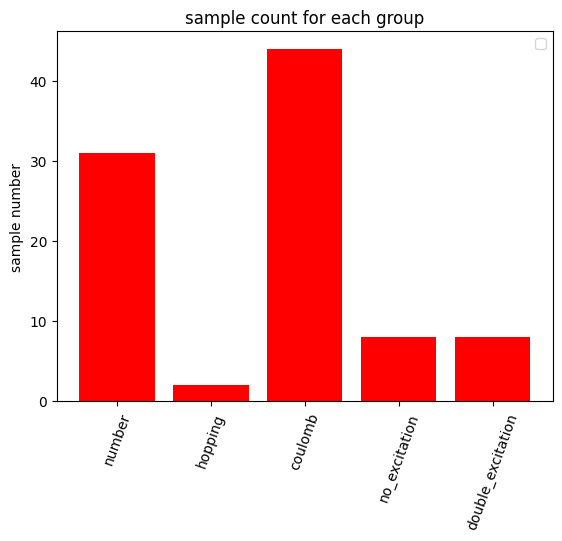

In [8]:
sample_hist(sg[-1],labels=['number', 'hopping', 'coulomb', 'no_excitation', 'double_excitation'],c='red')

In [9]:
gen_sys_param(n=n_qubits,sample_steps=secdepth[-1])
drift_time_evolution_parity = AlgorithmHamSimqDrift(initial_state_circ,[[h] for h in number_op+hopping_op+coulomb_op+no_excitation_op+double_excitation_op],[[c] for c in number_co+hopping_co+coulomb_co+no_excitation_co+double_excitation_co],t_max,n_qdrift_steps,seg,M=3)
Uq,sq,qdepth = drift_time_evolution_parity.Drift_exp(depth=secdepth[-1])

In [83]:
def Monte_Carlo_ave(t,U,depth,Ur,M=3):
    U_new = []
    U_mean = []
    for i in range(M):
        U_new.append(extract_U_at_t(t,U[i],depth[i]))
    for j in range(M):
        U_mean.append([np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(U_new[j],Ur)])
    return np.mean(U_mean,axis=0),np.std(U_mean,axis=0) 

In [34]:
def search_U_with_no_exp(idx,depth):
    count = 0
    idx_tmp = idx
    while idx_tmp>0:
        idx_tmp -= depth[count]
        count += 1
    count -= 1
    if abs(idx_tmp) > depth[count]//2:
        return count - 1
    else:
        return count
def extract_U_at_t(t,U,depth):
    if t[-1]/depth[-1] > t[0]:
        raise Exception('Get a smaller sample steps')
    U_new = [U[0]]
    t_step = t[-1]/depth[-1]
    for i in range(len(t)):
        idx = int(t[i] / t_step)
        U_new.append(U[search_U_with_no_exp(idx,depth)])
    return U_new

In [12]:
# U = [U2p,Ut,U2,Monte_Carlo_ave(Um),Monte_Carlo_ave(Ug),Monte_Carlo_ave(Uq)]
# depth = [secdepth,ldepth,secdepth,mdepth,gdepth,qdepth]
# labels = ['second protected','lie','second','group by site','group by particle_no','qdrift'] 

In [41]:
gen_sys_param(n=n_qubits,sample_steps=ldepth[-1])
Uexc = U_exc(drift_time_evolution.circuit.get_unitary(),n_qdrift_steps,t_max, H_matrix)

In [84]:
u2p = extract_U_at_t(t_list,U2p,secdepth)
ut = extract_U_at_t(t_list,Ut,ldepth)
u2 = extract_U_at_t(t_list,U2,secdepth)
uexc = extract_U_at_t(t_list,Uexc,np.arange(secdepth[-1]))
m_mean,m_std = Monte_Carlo_ave(t_list,Um,mdepth,uexc,M=3)
g_mean,g_std = Monte_Carlo_ave(t_list,Ug,gdepth,uexc,M=3)
q_mean,q_std = Monte_Carlo_ave(t_list,Uq,qdepth,uexc,M=3)

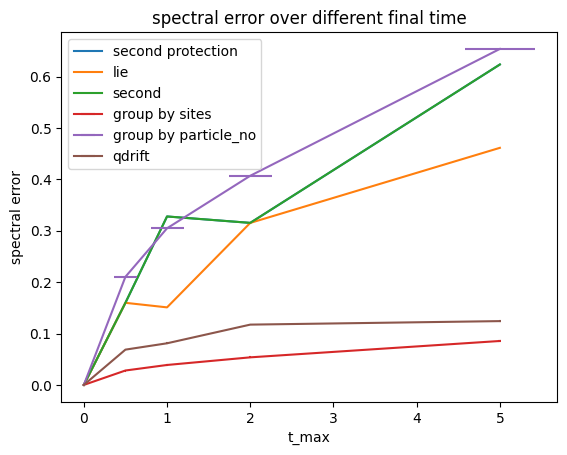

In [85]:
plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2p,uexc)],label='second protection')
plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(ut,uexc)],label='lie')
plt.plot([0]+t_list,[np.abs(linalg.eig(u - u_exc)[0]).max() for u,u_exc in zip(u2,uexc)],label='second')
plt.errorbar([0]+t_list,m_mean ,xerr=m_std, label='group by sites')
plt.errorbar([0]+t_list,g_mean ,xerr=g_std, label='group by particle_no')
plt.errorbar([0]+t_list,q_mean ,xerr=q_std, label='qdrift')
plt.title('spectral error over different final time')
plt.xlabel('t_max')
plt.ylabel('spectral error') 
plt.legend()